# DigiCow Farmer Training Adoption Challenge

## 1 Introduction

### 1.1 Aim: 
To predict which farmers will turn training into action

### 1.2 Problem Statement:
Access to high-quality agricultural training is just the first step toward improving productivity of farms. However, understanding which farmers adopt improved practices after training and why is a real challenge.

### 1.3 Business Understanding: 
DigiCow supports smallholder farmers through digital tools, extension services, and targetted training programmes. However, like many real-world interventions, adoption rates remain low and uneven. The ability to predict adoption early can enable DigiCow and its partners to prioritise follow-ups, tailor support more effectively, and design stronger extension strategies. 

### 1.4 Project Pitch: 
Predict the probability that a farmer will adopt a practice within 120 days of their first training, only using information available at the time of training. So the trained model must output predicted probabilities indicating the likelihood that a farmer will adopt a DigiCow-supported practice within the target time window (120 days of their first training). 

In [6]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

## 2 Dataset Overview

### 2.1 Data Loading

In [7]:
# Load datasets
train_df = pd.read_csv('data/Train.csv')
test_df = pd.read_csv('data/Test.csv')
sample_sub = pd.read_csv('data/SampleSubmission.csv')
description = pd.read_csv('data/dataset_data_dictionary.csv')

In [8]:
description

,column_name,description
0,ID,unique identifier for each farmer entry
1,gender,Gender of the farmer
2,age,Age category of the farmer
3,registration,Registration method
4,belong_to_cooperative,Whether the farmer belongs to a cooperative (1...
5,county,County of residence
6,subcounty,Sub-county of residence
7,ward,Ward of residence
8,trainer,Trainer who delivered the first training
9,topics_list,List of possible training topics


In [14]:
sample_sub.head(2)

,ID,Target_AUC,Target_LogLoss
0,ID_KYO5JS,0,0
1,ID_846C1K,0,0


In [15]:
train_df.head(2)

,ID,gender,age,registration,belong_to_cooperative,county,subcounty,ward,trainer,first_training_date,topics_list,num_trainings_30d,num_trainings_60d,num_total_trainings,num_repeat_trainings,days_to_second_training,num_unique_trainers,adopted_within_120_days,has_second_training
0,ID_QB363K,Female,Above 35,Ussd,1,Siaya,Alego Usonga,South East Alego,trainer_name_5,2024-07-07,"['Biosecurity In Poultry Farming,Calf Feeding,...",1.0,1.0,1,0,NaN,1,0,0
1,ID_J75OZ4,Female,Below 35,Ussd,0,Nandi,Chesumei,Lelmokwo Ngechek,trainer_name_3,2024-07-26,"['Calf Feeding,How To Rear A Calf With Unga Pr...",1.0,1.0,1,0,NaN,1,0,0


In [16]:
test_df.head(2)

,ID,gender,age,registration,belong_to_cooperative,county,subcounty,ward,trainer,first_training_date,topics_list,num_trainings_30d,num_trainings_60d,num_total_trainings,num_repeat_trainings,days_to_second_training,num_unique_trainers,has_second_training
0,ID_KYO5JS,Female,Below 35,Ussd,0,Siaya,Alego Usonga,West Alego,trainer_name_5,2024-07-10,"['Biosecurity In Poultry Farming,Calf Feeding,...",1.0,1.0,1,0,NaN,1,0
1,ID_846C1K,Male,Below 35,Ussd,0,Bungoma,Kanduyi,Musikoma,trainer_name_2,2024-07-20,"['Herd Health Management.,Poultry Health Manag...",1.0,1.0,1,0,NaN,1,0


### 2.2 Target Variable Analysis
- Based on the description df; the target variable is `adopted_within_120_days`.
- Perform high-level overview of the training and test datasets to investigate their respective structure and access readiness for modelling. 

In [9]:
# High-level datasets overview
print(f"\nTrain Dataset Shape: {train_df.shape}")
print(f"Test Dataset Shape: {test_df.shape}")
print(f"\nNumber of Features in Train: {train_df.shape[1]}")
print(f"Number of Features in Test: {test_df.shape[1]}")

# Check for target variable
if 'adopted_within_120_days' in train_df.columns and 'adopted_within_120_days' not in test_df.columns:
    print(f"\nTarget variable 'adopted_within_120_days' found in train set")
    print(f"Target variable absent from test set")
else:
    print("\n Check target variable presence!")


Train Dataset Shape: (11780, 19)
Test Dataset Shape: (5055, 18)

Number of Features in Train: 19
Number of Features in Test: 18

Target variable 'adopted_within_120_days' found in train set
Target variable absent from test set


In [17]:
# rename `adopted_within_120_days` to `target`
train_df=train_df.rename(columns={'adopted_within_120_days': 'target'})

- Investigate distribuction of the target variable and examine potential class imbalance. According to Xiao et al. (2024), a categorical target variable's scope of class imbalance is a crucial determinant factor for appropriate modelling strategies. 


Target Distribution:
target
0    11485
1      295
Name: count, dtype: int64

Target Proportions:
target
0    0.974958
1    0.025042
Name: proportion, dtype: float64


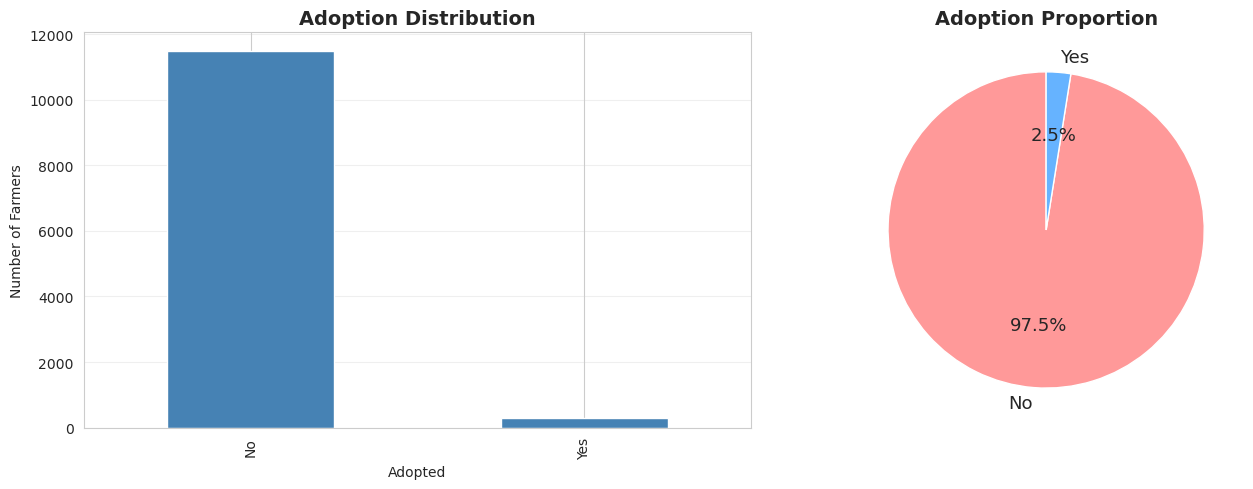


Class imbalance detected! Ratio: 38.93:1


In [23]:
# Target variable analysis
if 'target' in train_df.columns:
    print("\nTarget Distribution:")
    print(train_df['target'].value_counts().sort_index())
    print(f"\nTarget Proportions:")
    print(train_df['target'].value_counts(normalize=True).sort_index())
    
    # Create a mapping for target variable binary labels
    target_labels = {0: 'No', 1: 'Yes'}
    
    # Visualize target distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Count plot with renamed labels
    counts = train_df['target'].value_counts().sort_index()
    counts.index = counts.index.map(target_labels)          
    counts.plot(kind='bar', ax=axes[0], color='steelblue')
    axes[0].set_title('Adoption Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Adopted')
    axes[0].set_ylabel('Number of Farmers')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Pie chart with renamed labels
    target_counts = train_df['target'].value_counts().sort_index()
    target_counts.index = target_counts.index.map(target_labels) 
    axes[1].pie(target_counts, 
                 labels=target_counts.index,
                 autopct='%1.1f%%',
                 startangle=90,
                 colors=['#ff9999', '#66b3ff'],
                 textprops={'fontsize': 13})
    axes[1].set_title('Adoption Proportion', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Check for class imbalance 
    class_ratio = train_df['target'].value_counts().max() / train_df['target'].value_counts().min()
    if class_ratio > 1.5:
        print(f"\nClass imbalance detected! Ratio: {class_ratio:.2f}:1")
    else:
        print(f"\nClasses are relatively balanced. Ratio: {class_ratio:.2f}:1")

### 2.2 Basic Dataset Information

In [24]:
# Print 

print("\nTraining Dataset Information")
print(train_df.info())

print("\nTest Dataset Information")
print(test_df.info())


Training Dataset Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11780 entries, 0 to 11779
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       11780 non-null  object 
 1   gender                   11780 non-null  object 
 2   age                      11780 non-null  object 
 3   registration             11780 non-null  object 
 4   belong_to_cooperative    11780 non-null  int64  
 5   county                   11780 non-null  object 
 6   subcounty                11780 non-null  object 
 7   ward                     11780 non-null  object 
 8   trainer                  11780 non-null  object 
 9   first_training_date      11780 non-null  object 
 10  topics_list              11780 non-null  object 
 11  num_trainings_30d        11780 non-null  float64
 12  num_trainings_60d        11780 non-null  float64
 13  num_total_trainings      11780 non-null  int64

### 2.3 Missing Values Analysis


TRAIN SET - Columns with Missing Values:
                 Column  Missing_Count  Percentage
days_to_second_training          11667   99.040747


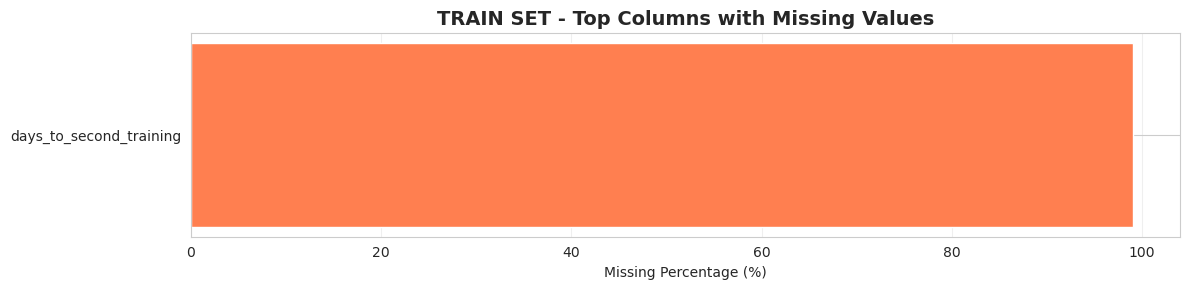


TEST SET - Columns with Missing Values:
                 Column  Missing_Count  Percentage
days_to_second_training           5007   99.050445


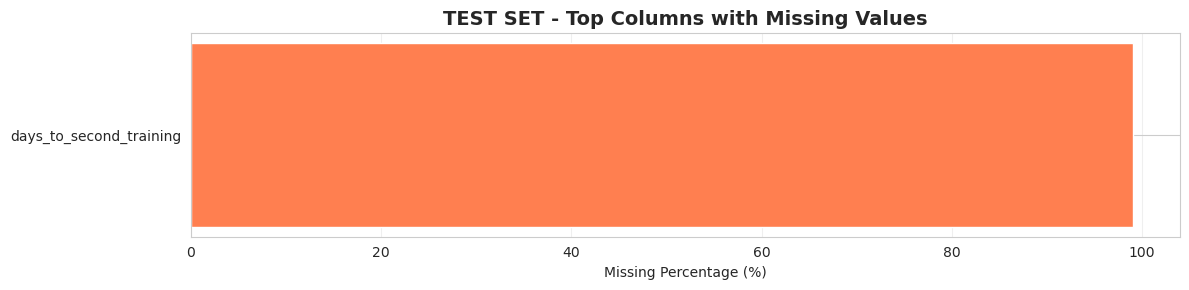

In [26]:
# Missing values check
def analyze_missing(df, name):
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing_Count': missing.values,
        'Percentage': missing_pct.values
    }).query('Missing_Count > 0').sort_values('Percentage', ascending=False)

    print(f"\n{name} - Columns with Missing Values:")
    if len(missing_df) > 0:
        print(missing_df.to_string(index=False))

        # Visualize top missing columns
        if len(missing_df) > 0:
            top_missing = missing_df.head(15)
            plt.figure(figsize=(12, 3))
            plt.barh(top_missing['Column'], top_missing['Percentage'], color='coral')
            plt.xlabel('Missing Percentage (%)')
            plt.title(f'{name} - Top Columns with Missing Values', fontsize=14, fontweight='bold')
            plt.gca().invert_yaxis()
            plt.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            plt.show()
    else:
        print("No missing values found!")

    return missing_df

train_missing = analyze_missing(train_df, "TRAIN SET")
test_missing = analyze_missing(test_df, "TEST SET")

- Due to the high percentage of missing data for the `days_to_second_training` for both the training and test datasets; the feature is eliminated.

In [27]:
# Remove the column from both dataframes
columns_to_drop = ['days_to_second_training']

train_df = train_df.drop(columns=columns_to_drop, errors='ignore')
test_df   = test_df.drop(columns=columns_to_drop,   errors='ignore')

### 2.4 Numerical Features Analysis

- Examine the numerical features to understand their respective distribuction, scales, and summary statistics. According to (), evaluating the distribuction of numerical features is critical for:
   1. Feature scalling and normalization.
   2. Outlier treatment.
   3. Informing appropriate modelling techniques. 

## References
1. Xiao, Y., Huang, J., Weng, W., Huang, R., Shao, Q., Zhou, C., & Li, S. (2024). Class imbalance: A crucial factor affecting the performance of tea plantations mapping by machine learning. International Journal of Applied Earth Observation and Geoinformation, 129, 103849. https://doi.org/10.1016/j.jag.2024.103849
2. 